# 人工衛星の撮影画像より車の分布地図を作成する．

- 本ファイルでは、航空写真を学習する画像分類のモデルを，学習済みのVGGモデルのFine Tuningにより構築し，車の分布地図の作成を試みます．


# 車のカウントの手順

1. 画像データからDatasetを作成できるようになる
2. DataSetからDataLoaderを作成できるようになる
3. 学習済みモデルの出力層を任意の形に変更できるようになる
4. VGG16モデルのFine tuningによるモデルを構築する．
5. 評価用の航空写真より車の分布地図の作成方法を確認する．
6. 公開されている高分解能の光学観測衛星の撮像画像より，学習モデルによる車の分布地図を作成する．



### 参考資料

作りながら学ぶ！pytorchによる発展ディープラーニング

https://github.com/YutaroOgawa/pytorch_advanced

[MIT License](https://github.com/YutaroOgawa/pytorch_advanced/blob/master/LICENSE)

In [1]:
# パッケージのimport
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms


In [2]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
print(torch.__version__)

1.1.0


In [4]:
print(torchvision.__version__)

0.3.0


# DataSetを作成

In [5]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # データオーギュメンテーション
                transforms.RandomHorizontalFlip(),  # データオーギュメンテーション
                transforms.RandomVerticalFlip(), # データオーギュメンテーション
                transforms.RandomAffine([-30, 30], scale=(0.8, 1.2)),  # 回転とリサイズ
                #transforms.RandomErasing(p=0.5),  # 確率0.5でランダムに領域を消去
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                #transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)


In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform_val():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # データオーギュメンテーション
                #transforms.RandomHorizontalFlip(),  # データオーギュメンテーション
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                #transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)


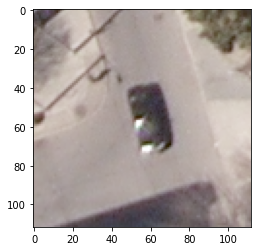

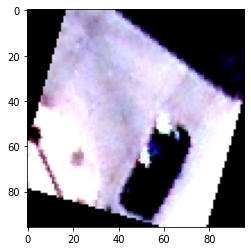

In [8]:
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる

# 1. 画像読み込み
image_file_path = '../data/train/01/03553_97_597.png'
img = Image.open(image_file_path)   # [高さ][幅][色RGB]

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
size = 96
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()


In [9]:
# 0から20のTrainデータへのファイルパスのリストを作成する


def make_datapath_list(phase="train"):
    """
    データのパスを格納したリストを作成する。

    Parameters
    ----------
    phase : 'train' or 'val'
        訓練データか検証データかを指定する

    Returns
    -------
    path_list : list
        データへのパスを格納したリスト
    """

    rootpath = "../data/"
    target_path = osp.join(rootpath+phase+'/**/*.png')
    print(target_path)

    path_list = []  # ここに格納する

    # globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


# 実行
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

#train_list


../data/train/**/*.png
../data/val/**/*.png


In [10]:
len(train_list), len(val_list)

(37981, 10267)

In [11]:
# 0から1の画像のDatasetを作成する


class CarCountDataset(torch.utils.data.Dataset):
    """
    車の数の画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベルをファイル名から抜き出す
        if self.phase == "train":
            label = img_path[14:16]
            #print(label)
        elif self.phase == "val":
            #print(img_path)
            label = img_path[12:14]
            #print(label)

        # ラベルを数値に変更する
        if label == "00":
            label = 0
        elif label == "01":
            label = 1
        elif label == "02":
            label = 2
        elif label == "03":
            label = 3
        elif label == "04":
            label = 4
        elif label == "05":
            label = 5
        elif label == "06":
            label = 6
        elif label == "07":
            label = 7
        elif label == "08":
            label = 8
        elif label == "09":
            label = 9
        elif label == "10":
            label = 10
        elif label == "11":
            label = 11
        elif label == "12":
            label = 12
        #elif label == "13": #calが１2までなので，trainはそれ以上を１２台に含めた．
        #    label = 13
        #elif label == "14":
        #    label = 14
        #elif label == "15":
        #    label = 15
        #elif label == "16":
        #    label = 16
        #elif label == "17":
        #    label = 17
        #elif label == "18":
        #    label = 18
        #elif label == "19":
        #    label = 19
        #elif label == "20":
        #    label = 20
       
        
        #print(type(label))
        return img_transformed, label

#Augment

# 実行
train_dataset = CarCountDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = CarCountDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 96, 96])
12


# DataLoaderを作成

In [12]:
# ミニバッチのサイズを指定
batch_size = 32

# DataLoaderを作成



train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

print(type(dataloaders_dict))
print(dataloaders_dict["train"])
print(dataloaders_dict)
# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
print(type(batch_iterator))
inputs, labels = next(
    batch_iterator)  # 1番目の要素を取り出す
#print(inputs.size())
#print(labels)
#print(labels.size())

<class 'dict'>
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f933cf74f90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f933cf742d0>}
<class 'torch.utils.data.dataloader._DataLoaderIter'>


# ネットワークモデルの作成する
VGG-16を使ってみる．

In [13]:
# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)
#net = torchvision.models.resnet50(pretrained=use_pretrained)
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [14]:
# ResNET50の最後の出力層の出力ユニットを21の車の数のクラスに付け替える
net.classifier[6] = nn.Linear(in_features=4096, out_features=13)
#net.fc = nn.Linear(in_features=4096, out_features=13)


# 訓練モードに設定
net.train()

print('ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました')

ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました


In [15]:
# ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 学習させる層のパラメータ名を指定
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# パラメータごとに各リストに格納する
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3に格納：", name)

    else:
        param.requires_grad = False
        print("勾配計算なし。学習しない：", name)

params_to_update_1に格納： features.0.weight
params_to_update_1に格納： features.0.bias
params_to_update_1に格納： features.2.weight
params_to_update_1に格納： features.2.bias
params_to_update_1に格納： features.5.weight
params_to_update_1に格納： features.5.bias
params_to_update_1に格納： features.7.weight
params_to_update_1に格納： features.7.bias
params_to_update_1に格納： features.10.weight
params_to_update_1に格納： features.10.bias
params_to_update_1に格納： features.12.weight
params_to_update_1に格納： features.12.bias
params_to_update_1に格納： features.14.weight
params_to_update_1に格納： features.14.bias
params_to_update_1に格納： features.17.weight
params_to_update_1に格納： features.17.bias
params_to_update_1に格納： features.19.weight
params_to_update_1に格納： features.19.bias
params_to_update_1に格納： features.21.weight
params_to_update_1に格納： features.21.bias
params_to_update_1に格納： features.24.weight
params_to_update_1に格納： features.24.bias
params_to_update_1に格納： features.26.weight
params_to_update_1に格納： features.26.bias
params_to_update_1に格納： f

# 損失関数を定義

In [16]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# 最適化手法を設定

In [17]:
# 最適化手法の設定
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)


In [18]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# 学習・検証を実施

In [19]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # 初期設定
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #print("使用デバイス：", device)
    print("device name", torch.cuda.get_device_name(0))

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True
    
    #train accurascy, train loss, val_accuracy, val_loss をグラフ化できるように設定．
    x_epoch_data=[]
    y_train_loss=[]
    y_train_accuracy=[]
    y_val_loss=[]
    y_val_accuracy=[]

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')
        
        x_epoch_data.append(epoch)

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # GPUが使えるならGPUにデータを送る
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 結果の計算
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            
            if phase == 'train':
                y_train_loss.append(epoch_loss)
                y_train_accuracy.append(epoch_acc)
            else:
                y_val_loss.append(epoch_loss)
                y_val_accuracy.append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
    return x_epoch_data, y_train_loss, y_train_accuracy, y_val_loss, y_val_accuracy


In [20]:
# 学習・検証を実行する

num_epochs=50
train = train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

device name GeForce GTX 1070


  0%|          | 0/321 [00:00<?, ?it/s]

Epoch 1/50
-------------


  0%|          | 0/1187 [00:00<?, ?it/s]

val Loss: 2.6947 Acc: 0.0631
Epoch 2/50
-------------


  1%|          | 2/321 [00:00<00:19, 16.35it/s]

train Loss: 1.1999 Acc: 0.5916


  0%|          | 1/1187 [00:00<03:00,  6.57it/s]

val Loss: 0.9054 Acc: 0.6730
Epoch 3/50
-------------


  1%|          | 2/321 [00:00<00:17, 18.33it/s]

train Loss: 1.0080 Acc: 0.6380


  0%|          | 1/1187 [00:00<03:02,  6.50it/s]

val Loss: 0.9374 Acc: 0.6647
Epoch 4/50
-------------


  1%|          | 2/321 [00:00<00:18, 17.32it/s]

train Loss: 0.9379 Acc: 0.6608


  0%|          | 1/1187 [00:00<02:57,  6.70it/s]

val Loss: 0.8753 Acc: 0.6879
Epoch 5/50
-------------


  1%|          | 3/321 [00:00<00:15, 20.05it/s]

train Loss: 0.8944 Acc: 0.6721


  0%|          | 1/1187 [00:00<02:48,  7.02it/s]

val Loss: 0.8236 Acc: 0.7072
Epoch 6/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.68it/s]

train Loss: 0.8628 Acc: 0.6817


  0%|          | 1/1187 [00:00<02:50,  6.94it/s]

val Loss: 0.7977 Acc: 0.7220
Epoch 7/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.57it/s]

train Loss: 0.8449 Acc: 0.6897


  0%|          | 1/1187 [00:00<02:50,  6.96it/s]

val Loss: 0.8152 Acc: 0.7096
Epoch 8/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.87it/s]

train Loss: 0.8223 Acc: 0.6955


  0%|          | 1/1187 [00:00<02:49,  6.99it/s]

val Loss: 0.7267 Acc: 0.7375
Epoch 9/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.35it/s]

train Loss: 0.8109 Acc: 0.7007


  0%|          | 1/1187 [00:00<02:50,  6.97it/s]

val Loss: 0.7899 Acc: 0.7172
Epoch 10/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.83it/s]

train Loss: 0.7920 Acc: 0.7089


  0%|          | 1/1187 [00:00<02:49,  6.98it/s]

val Loss: 0.7301 Acc: 0.7388
Epoch 11/50
-------------


  1%|          | 2/321 [00:00<00:15, 19.95it/s]

train Loss: 0.7886 Acc: 0.7087


  0%|          | 1/1187 [00:00<02:54,  6.79it/s]

val Loss: 0.7043 Acc: 0.7510
Epoch 12/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.67it/s]

train Loss: 0.7695 Acc: 0.7142


  0%|          | 1/1187 [00:00<02:49,  7.00it/s]

val Loss: 0.7291 Acc: 0.7443
Epoch 13/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.73it/s]

train Loss: 0.7628 Acc: 0.7161


  0%|          | 1/1187 [00:00<02:52,  6.88it/s]

val Loss: 0.7109 Acc: 0.7501
Epoch 14/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.36it/s]

train Loss: 0.7590 Acc: 0.7201


  0%|          | 1/1187 [00:00<02:55,  6.76it/s]

val Loss: 0.7720 Acc: 0.7291
Epoch 15/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.05it/s]

train Loss: 0.7553 Acc: 0.7218


  0%|          | 1/1187 [00:00<02:51,  6.91it/s]

val Loss: 0.7256 Acc: 0.7489
Epoch 16/50
-------------


  1%|          | 2/321 [00:00<00:16, 18.82it/s]

train Loss: 0.7509 Acc: 0.7235


  0%|          | 1/1187 [00:00<02:54,  6.81it/s]

val Loss: 0.7025 Acc: 0.7585
Epoch 17/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.61it/s]

train Loss: 0.7436 Acc: 0.7257


  0%|          | 1/1187 [00:00<02:49,  6.99it/s]

val Loss: 0.7147 Acc: 0.7511
Epoch 18/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.06it/s]

train Loss: 0.7394 Acc: 0.7268


  0%|          | 1/1187 [00:00<02:50,  6.96it/s]

val Loss: 0.8255 Acc: 0.7156
Epoch 19/50
-------------


  1%|          | 2/321 [00:00<00:18, 17.30it/s]

train Loss: 0.7296 Acc: 0.7283


  0%|          | 1/1187 [00:00<02:58,  6.65it/s]

val Loss: 0.7505 Acc: 0.7413
Epoch 20/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.71it/s]

train Loss: 0.7247 Acc: 0.7316


  0%|          | 1/1187 [00:00<02:57,  6.69it/s]

val Loss: 0.6804 Acc: 0.7640
Epoch 21/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.02it/s]

train Loss: 0.7254 Acc: 0.7318


  0%|          | 1/1187 [00:00<02:51,  6.91it/s]

val Loss: 0.6756 Acc: 0.7698
Epoch 22/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.26it/s]

train Loss: 0.7200 Acc: 0.7351


  0%|          | 1/1187 [00:00<02:51,  6.92it/s]

val Loss: 0.7360 Acc: 0.7503
Epoch 23/50
-------------


  1%|          | 2/321 [00:00<00:16, 18.99it/s]

train Loss: 0.7094 Acc: 0.7342


  0%|          | 1/1187 [00:00<02:56,  6.74it/s]

val Loss: 0.7118 Acc: 0.7492
Epoch 24/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.41it/s]

train Loss: 0.7134 Acc: 0.7353


  0%|          | 1/1187 [00:00<02:52,  6.86it/s]

val Loss: 0.7008 Acc: 0.7556
Epoch 25/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.64it/s]

train Loss: 0.7128 Acc: 0.7367


  0%|          | 1/1187 [00:00<02:50,  6.97it/s]

val Loss: 0.6872 Acc: 0.7608
Epoch 26/50
-------------


  1%|          | 2/321 [00:00<00:15, 19.95it/s]

train Loss: 0.7042 Acc: 0.7372


  0%|          | 1/1187 [00:00<02:58,  6.63it/s]

val Loss: 0.7204 Acc: 0.7483
Epoch 27/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.86it/s]

train Loss: 0.7019 Acc: 0.7405


  0%|          | 1/1187 [00:00<02:56,  6.73it/s]

val Loss: 0.7431 Acc: 0.7456
Epoch 28/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.11it/s]

train Loss: 0.6970 Acc: 0.7411


  0%|          | 1/1187 [00:00<02:50,  6.95it/s]

val Loss: 0.6966 Acc: 0.7609
Epoch 29/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.10it/s]

train Loss: 0.6968 Acc: 0.7453


  0%|          | 1/1187 [00:00<02:50,  6.97it/s]

val Loss: 0.6681 Acc: 0.7665
Epoch 30/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.00it/s]

train Loss: 0.6896 Acc: 0.7441


  0%|          | 1/1187 [00:00<02:49,  7.00it/s]

val Loss: 0.6848 Acc: 0.7613
Epoch 31/50
-------------


  1%|          | 2/321 [00:00<00:17, 18.64it/s]

train Loss: 0.6898 Acc: 0.7440


  0%|          | 1/1187 [00:00<02:54,  6.78it/s]

val Loss: 0.7294 Acc: 0.7485
Epoch 32/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.05it/s]

train Loss: 0.6810 Acc: 0.7449


  0%|          | 1/1187 [00:00<02:49,  7.02it/s]

val Loss: 0.7431 Acc: 0.7483
Epoch 33/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.55it/s]

train Loss: 0.6819 Acc: 0.7463


  0%|          | 1/1187 [00:00<02:51,  6.91it/s]

val Loss: 0.7058 Acc: 0.7587
Epoch 34/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.03it/s]

train Loss: 0.6866 Acc: 0.7423


  0%|          | 1/1187 [00:00<02:50,  6.96it/s]

val Loss: 0.6616 Acc: 0.7702
Epoch 35/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.74it/s]

train Loss: 0.6810 Acc: 0.7457


  0%|          | 1/1187 [00:00<02:48,  7.04it/s]

val Loss: 0.6390 Acc: 0.7779
Epoch 36/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.86it/s]

train Loss: 0.6766 Acc: 0.7467


  0%|          | 1/1187 [00:00<02:49,  7.01it/s]

val Loss: 0.6432 Acc: 0.7720
Epoch 37/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.87it/s]

train Loss: 0.6753 Acc: 0.7468


  0%|          | 1/1187 [00:00<02:49,  6.98it/s]

val Loss: 0.6671 Acc: 0.7684
Epoch 38/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.84it/s]

train Loss: 0.6702 Acc: 0.7510


  0%|          | 1/1187 [00:00<02:51,  6.90it/s]

val Loss: 0.7300 Acc: 0.7514
Epoch 39/50
-------------


  1%|          | 2/321 [00:00<00:17, 18.73it/s]

train Loss: 0.6676 Acc: 0.7529


  0%|          | 1/1187 [00:00<02:53,  6.82it/s]

val Loss: 0.7740 Acc: 0.7431
Epoch 40/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.79it/s]

train Loss: 0.6695 Acc: 0.7504


  0%|          | 1/1187 [00:00<02:52,  6.88it/s]

val Loss: 0.6859 Acc: 0.7628
Epoch 41/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.91it/s]

train Loss: 0.6652 Acc: 0.7532


  0%|          | 1/1187 [00:00<02:51,  6.93it/s]

val Loss: 0.6826 Acc: 0.7640
Epoch 42/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.72it/s]

train Loss: 0.6663 Acc: 0.7529


  0%|          | 1/1187 [00:00<03:17,  6.00it/s]

val Loss: 0.6701 Acc: 0.7674
Epoch 43/50
-------------


  1%|          | 2/321 [00:00<00:18, 17.33it/s]

train Loss: 0.6650 Acc: 0.7506


  0%|          | 1/1187 [00:00<03:07,  6.33it/s]

val Loss: 0.6960 Acc: 0.7619
Epoch 44/50
-------------


  1%|          | 2/321 [00:00<00:19, 16.59it/s]

train Loss: 0.6585 Acc: 0.7540


  0%|          | 1/1187 [00:00<03:06,  6.36it/s]

val Loss: 0.6998 Acc: 0.7634
Epoch 45/50
-------------


  1%|          | 2/321 [00:00<00:18, 17.57it/s]

train Loss: 0.6599 Acc: 0.7519


  0%|          | 1/1187 [00:00<02:59,  6.62it/s]

val Loss: 0.6330 Acc: 0.7786
Epoch 46/50
-------------


  1%|          | 2/321 [00:00<00:17, 18.13it/s]

train Loss: 0.6583 Acc: 0.7539


  0%|          | 1/1187 [00:00<03:03,  6.45it/s]

val Loss: 0.6980 Acc: 0.7608
Epoch 47/50
-------------


  1%|          | 2/321 [00:00<00:18, 17.01it/s]

train Loss: 0.6554 Acc: 0.7549


  0%|          | 1/1187 [00:00<02:58,  6.63it/s]

val Loss: 0.7039 Acc: 0.7622
Epoch 48/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.76it/s]

train Loss: 0.6488 Acc: 0.7558


  0%|          | 1/1187 [00:00<02:57,  6.67it/s]

val Loss: 0.6977 Acc: 0.7610
Epoch 49/50
-------------


  1%|          | 2/321 [00:00<00:17, 17.81it/s]

train Loss: 0.6453 Acc: 0.7579


  0%|          | 1/1187 [00:00<02:58,  6.64it/s]

val Loss: 0.6881 Acc: 0.7656
Epoch 50/50
-------------


  1%|          | 2/321 [00:00<00:16, 19.76it/s]

train Loss: 0.6499 Acc: 0.7555


100%|██████████| 321/321 [00:17<00:00, 18.45it/s]

val Loss: 0.7465 Acc: 0.7506


In [21]:
train_epoch = train[0].copy()
train_epoch.pop(0)

0

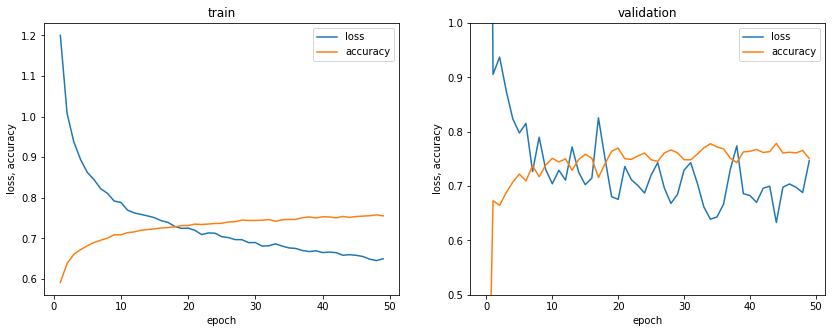

In [123]:
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(1, 2, 1)
line1, = ax1.plot(train_epoch,train[1],label='loss') 
line2, = ax1.plot(train_epoch,train[2],label='accuracy')
ax1.set_title("train")
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss, accuracy')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 2, 2)
line1, = ax2.plot(train[0],train[3],label='loss')
line2, = ax2.plot(train[0],train[4],label='accuracy') 
ax2.set_ylim(0.5, 1.0) #y軸のスケールを固定．
ax2.set_title("validation")
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss, accuracy')
ax2.legend(loc='upper right')

plt.show()

In [24]:
# PyTorchのネットワークパラメータの保存
save_path = './carcount_weights_fine_tuning.pth'
torch.save(net.state_dict(), save_path)

## 学習済みモデルの再生
学習したモデルを再生し，モデルの検証を行います．


Save on GPU, Load on GPU

https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [25]:
device = torch.device("cuda")

load_path = './carcount_weights_fine_tuning.pth'
net.load_state_dict(torch.load(load_path))
net.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## 正解率の算出
モデルの性能を把握するため、テストデータ使い正解率を測定します。  

In [26]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(val_dataloader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 75.05600467517289%


## 訓練済みのモデルを使った予測
訓練済みのモデルを使ってみましょう。  
画像を入力し、モデルが機能していることを確かめます。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


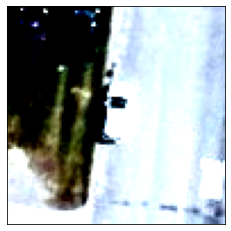

torch.Size([32, 3, 96, 96])
予測された車の数: 3
正解の車の数: tensor(3, device='cuda:0')


In [27]:

test_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True)

dataiter = iter(test_dataloader)
images, labels = dataiter.next()  # サンプルを1つだけ取り出す

plt.imshow(np.transpose(images[0], (1, 2, 0)))  # チャンネルを一番後ろに
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.show()

net.eval()  # 評価モード
x, t = images.cuda(), labels.cuda()  # GPU対応
print(x.shape)
#x, t = images, labels # CPU対応
y = net(x)
print("予測された車の数:", y[0].argmax().item())
print('正解の車の数:', t[0])

## 車の台数毎の予測精度
訓練済みのモデルを使ってみましょう。  
画像を入力し、モデルが機能していることを確かめます。

In [28]:
# ミニバッチのサイズを指定
batch_size = 32


val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

classes = list(range(13))
class_correct = list(0. for i in range(13))
class_total = list(0. for i in range(13))
predicted_class = list(0. for i in range(13))


dataiter = iter(val_dataloader)
images, labels = dataiter.next() 

net.eval()  # 評価モード
x, t = images, labels # GPU対応

for data in val_dataloader:
    images, labels = data
    x, t = images.cuda(), labels.cuda()  # GPU対応
    #x, t = images, labels  # CPU対応
    outputs = net(x)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == t).squeeze()

    for i in range(len(c)):
        label = t[i]
        label_p = predicted[i]
        class_correct[label] += c[i].item()
        predicted_class[label_p] += 1
        class_total[label] += 1
  
    

for i in range(13):
    print('Accuracy of %2s : %2d %%, %4d images, the number of predicted image: %4d' % (
        classes[i], 100 * class_correct[i] / class_total[i], class_total[i], predicted_class[i]))

Accuracy of  0 : 94 %, 5773 images, the number of predicted image: 5618
Accuracy of  1 : 68 %, 1546 images, the number of predicted image: 1419
Accuracy of  2 : 52 %, 1171 images, the number of predicted image:  976
Accuracy of  3 : 47 %,  733 images, the number of predicted image:  878
Accuracy of  4 : 26 %,  465 images, the number of predicted image:  449
Accuracy of  5 : 26 %,  284 images, the number of predicted image:  370
Accuracy of  6 : 12 %,  153 images, the number of predicted image:  107
Accuracy of  7 : 21 %,   76 images, the number of predicted image:  237
Accuracy of  8 :  0 %,   40 images, the number of predicted image:   12
Accuracy of  9 : 25 %,   12 images, the number of predicted image:  106
Accuracy of 10 : 12 %,    8 images, the number of predicted image:   43
Accuracy of 11 :  0 %,    5 images, the number of predicted image:   21
Accuracy of 12 : 100 %,    1 images, the number of predicted image:   31


# 検証用画像で予測を可視化（車分布マップ）を作成する．

In [29]:
import argparse
import os
import shutil
import math
import numpy as np
from PIL import Image
from skimage import io
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

import cv2


Image.MAX_IMAGE_PIXELS = 1000000000

In [30]:
if not os.path.exists('../data/test'):
    os.mkdir('../data/test')

In [31]:
val_path = '../cowc_car_counting/data/cowc/datasets/ground_truth_sets/Utah_AGRC/'
files =os.listdir(val_path)

#ファイル名の取得
print(files[0])

12TVL160640-CROP.png


v_size: 7213
h_size: 7226


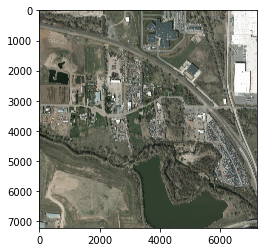

In [32]:
#opencvで検証用画像を読み込む．

im = cv2.imread(val_path + files[0])
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#Image.fromarray(im_rgb).save('test.jpg')

plt.imshow(im_rgb)

#画像サイズの確認
v_size = im_rgb.shape[0]
h_size = im_rgb.shape[1]
print('v_size:', v_size)
print('h_size:', h_size)

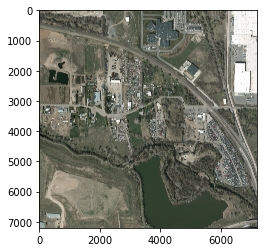

In [33]:
#PILで画像の読み込み
img = Image.open(val_path + files[0])

#画像サイズを7213なので，これに近い7200にリサイズ．
img_size = 7200

#画像のリサイズ・標準処理
img_resize=img.resize((img_size,img_size))
plt.imshow(img_resize)

In [34]:
#検証画像の分割画像の置き場所を準備する．

if not os.path.exists('../data/test/val'):
    os.mkdir('../data/test/val')

In [35]:
height = 100 #モデルが96ピクセルなので，それに近い100ピクセルとする．
width = 100
img_size = 7200 #imageサイズで100ピクセルに近い値とする．

DIR_OUTPUTS = '../data/test/val/'

#画像の分割処理関数
def ImgSplit(im):
    # 読み込んだ画像を100*100ピクセルのサイズに分割する．のサイズで72*72枚に分割する

    buff = []
    # 縦の分割枚数
    for h1 in range(int(img_size/height)):
        # 横の分割枚数
        for w1 in range(int(img_size/width)):
            w2 = w1 * height
            h2 = h1 * width
            #print(w2, h2, width + w2, height + h2)
            c = im.crop((w2, h2, width + w2, height + h2))
            buff.append(c)
    return buff

#画像の分割処理の実行
hi=0
for ig in ImgSplit(img_resize):
    hi=hi+1
    #print(hi)
    # 保存先フォルダの指定
    ig.save(DIR_OUTPUTS+str(hi)+".png")

In [36]:
#test_listの作成

def make_datapath_list_test(phase="test"):
    """
    データのパスを格納したリストを作成する。

    Parameters
    ----------
    phase : 'train' or 'val'
        訓練データか検証データかを指定する

    Returns
    -------
    path_list : list
        データへのパスを格納したリスト
    """

    rootpath = "../data/"
    target_path = osp.join(rootpath+phase+'/val/*.png')
    print(target_path)

    path_list = []  # ここに格納する

    # globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


# 実行
test_list = make_datapath_list_test(phase="test")


../data/test/val/*.png


In [37]:
# test画像の前処理をするクラス
# resize, normalize and totnesorを行う．

class ImageTransform_test():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'test': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                #transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='test'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

test_listのファイルの順番は番号順になっていないため，natsortを用いて順番に変更する．
natsortをインストールしていない場合は，以下を実行する．

In [38]:
#!pip install natsort

In [39]:
#natsoatを用いてファイルの順番をソートする

from natsort import natsorted

test_list = natsorted(test_list)

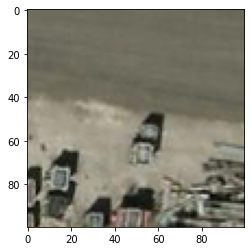

torch.Size([3, 96, 96])


In [40]:
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる

# 1. 画像読み込み
image_file_path = test_list[0]
img = Image.open(image_file_path).convert('RGB')   # [高さ][幅][色RGB]

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
size = 96
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="val")  # torch.Size([3, 224, 224])

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
print(img_transformed.shape)

In [41]:
# test画像のDatasetを作成する

class CarCountDataset_test(torch.utils.data.Dataset):
    """
    車の数の画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path).convert('RGB')   # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベルをファイル名から抜き出す
        label == 0
        return img_transformed, label


# 実行
test_dataset = CarCountDataset_test(
    file_list=test_list, transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 0
print(test_dataset.__getitem__(index)[0].size())
print(test_dataset.__getitem__(index)[1])

torch.Size([3, 96, 96])
tensor(1, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


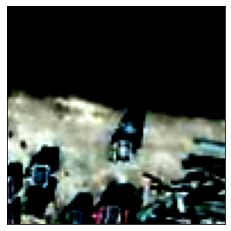

torch.Size([10, 3, 96, 96])
予測された車の数: 0
元の画像の表示


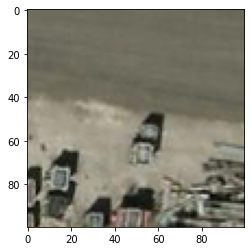

In [42]:
batch_size =10

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

dataiter = iter(test_dataloader)
images, labels = dataiter.next()  # サンプルを1つだけ取り出す

plt.imshow(np.transpose(images[0], (1, 2, 0)))  # チャンネルを一番後ろに
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.show()

net.eval()  # 評価モード
x, t = images.cuda(), labels.cuda()  # GPU対応
print(x.shape)
#x, t = images, labels # CPU対応
y = net(x)
print("予測された車の数:", y[0].argmax().item())

# 2. 元の画像の表示
print('元の画像の表示')
plt.imshow(img)
plt.show()

分割した画像データよりモデルを用いて車の台数を算出する．
求めた車の台数のマップ（行列）を作成する．

In [43]:
# ミニバッチのサイズを指定
batch_size = 10

#対象画像のdataloaderを作成
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

classes = list(range(13))
class_correct = list(0. for i in range(13))
class_total = list(0. for i in range(13))


net.eval()  # 評価モード

test =[]
i = 0

for data in test_dataloader:
    images, labels = data
    x, t = images.cuda(), labels.cuda() # GPU対応
    #x, t = images, labels  # CPU対応
  
    y = net(x)
    for i in range(len(y)):
        result = y[i].argmax().item() #GPUのtensorをnpに変換するにはargmaxを用いる必要がある．
        test.append(result)
    
print('分割された画像の数: ',len(test))

分割された画像の数:  5184


In [44]:
test2 = np.array(test)
cars_counted =test2.reshape(72, 72)

In [45]:
cars_counted

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [46]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import itertools

%matplotlib inline

In [47]:
#検証画像をベース画像として準備．

image_path = val_path + files[0] 
mosaic_image = io.imread(image_path)[:, :, :3]

車の分布地図は下記のサイトのコードを参考にしています．

COWC Car Counting
https://github.com/motokimura/cowc_car_counting

[MIT License](https://github.com/motokimura/cowc_car_counting/blob/master/LICENSE)

In [48]:
car_max = 12 #label classes
class_num = car_max + 1
grid_size = width # width, vertical = 100

In [49]:
def get_color_map(sns_palette):
    
    color_map = np.empty(shape=[0, 3], dtype=np.uint8)

    for color in sns_palette:
        r = int(color[0] * 255)
        g = int(color[1] * 255)
        b = int(color[2] * 255)
        rgb_byte = np.array([[r, g, b]], dtype=np.uint8)
        color_map = np.append(color_map, rgb_byte, axis=0)
    
    return color_map


def overlay_heatmap(
    cars, background_image, car_max, grid_size, cmap, 
    line_rgb=[0, 0, 0], line_thickness=2, alpha=0.5, min_car_to_show=1, background_rgb=[0, 0, 0]):
    
    yi_max, xi_max = cars.shape

    result = background_image.copy()
    heatmap = background_image.copy()

    sns_palette = sns.color_palette(cmap, n_colors=car_max + 1)
    color_map = get_color_map(sns_palette)
    
    for yi in range(yi_max):
        for xi in range(xi_max):
            
            top, left = yi * grid_size, xi * grid_size
            bottom, right = top + grid_size, left + grid_size
            
            cars_counted = cars[yi, xi]

            if cars_counted < min_car_to_show:
                if background_rgb is not None:
                    heatmap[top:bottom, left:right] = np.array(background_rgb)
            else:
                heatmap[top:bottom, left:right] = color_map[cars_counted]

                if line_thickness > 0:
                    cv2.rectangle(heatmap, (left, top), (right, bottom), line_rgb, thickness=line_thickness)
    
    cv2.addWeighted(heatmap, alpha, result, 1 - alpha, 0, result)

    return result

In [50]:
if not os.path.exists('../data/result'):
    os.mkdir('../data/result')

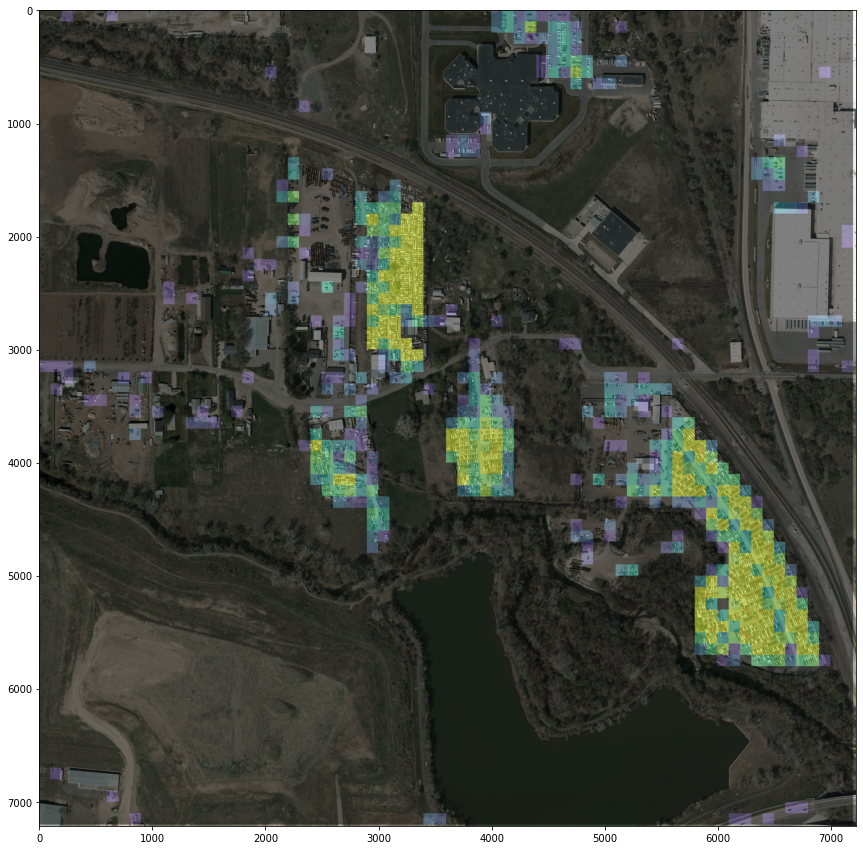

In [51]:
heatmap_overlayed = overlay_heatmap(cars_counted, mosaic_image, car_max, grid_size, cmap='viridis', line_thickness=-1)

fig = plt.figure(figsize=(15, 15))
plt.imshow(heatmap_overlayed)


plt.imsave('../data/result/heatmap_' + files[0], heatmap_overlayed)

### ベースマップに車の台数を表示させる

In [52]:
heatmap_overlayed_2 = overlay_heatmap(cars_counted, mosaic_image, car_max, grid_size, cmap='Reds')

In [53]:
def plot_counts_on_heatmap_2(heatmap_overlayed, aoi_tblr, cars, grid_size, min_car_to_show=1, figsize=(15, 15)):
    
    top, bottom, left, right = aoi_tblr
    
    yi_min, xi_min = int(math.floor(top / grid_size)), int(math.floor(left / grid_size))
    yi_max, xi_max = int(math.ceil(bottom / grid_size)), int(math.ceil(right / grid_size))
    
    top, left, bottom, right = yi_min * grid_size, xi_min * grid_size, yi_max * grid_size, xi_max * grid_size
    
    fig = plt.figure(figsize=figsize)
    plt.imshow(heatmap_overlayed[top:bottom, left:right])
    
    for (yi, xi) in itertools.product(range(yi_min, yi_max), range(xi_min, xi_max)):
        
        car_num = cars[yi, xi]
        if car_num < min_car_to_show:
            continue
        
        plt.text(
            (xi + 0.5) * grid_size - left, (yi + 0.5) * grid_size - top, format(car_num, 'd'), 
            horizontalalignment="center", verticalalignment="center", color="black"
        )
    
    plt.show()
    fig.savefig('../data/result/heatmap_carcount_' + files[0])

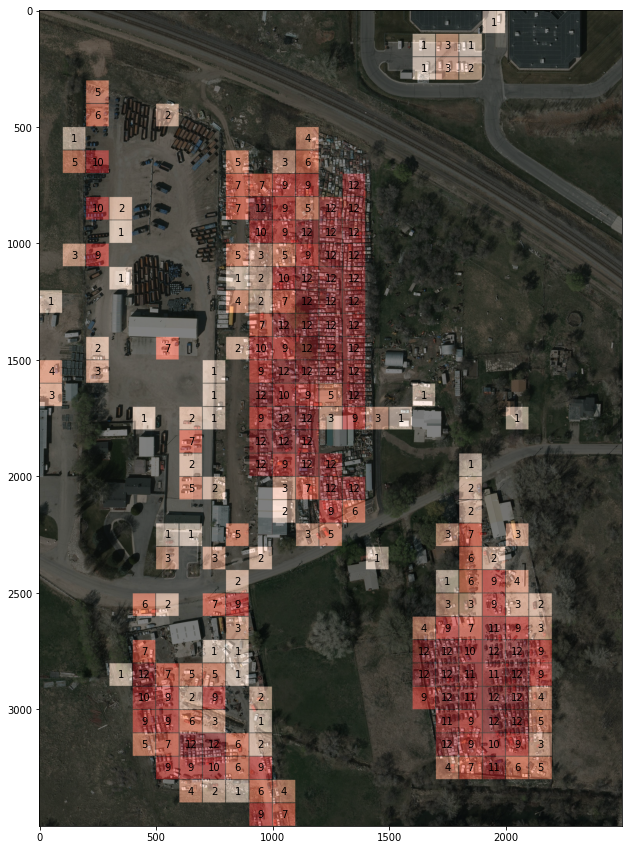

In [54]:
top, bottom, left, right = 1000, 4500, 2000, 4500
heatmap_carcount = plot_counts_on_heatmap_2(heatmap_overlayed_2, (top, bottom, left, right), cars_counted, grid_size)

## 人工衛星の撮像画像の車をカウントする．

モデルは，上記で航空写真より構築したものを用いる．
デモンストレーションする人工衛星の撮像画像は，Worldview-3の観測画像．
人工衛星の撮像画像は分解能が30cmであり，航空写真の15cmの半分の解像度．


[WorldView-3 Satellite Sensor](https://www.satimagingcorp.com/satellite-sensors/worldview-3/)

In [92]:
if not os.path.exists('../data/test/demo'):
    os.mkdir('../data/test/demo')
    
if not os.path.exists('../data/test/demo/image'):
    os.mkdir('../data/test/demo/image')

In [93]:
!wget -P ../data/test/demo https://content.satimagingcorp.com/static/galleryimages/Satellite-Image-2016-Olympics-Rio-De-Janeiro.jpg 

--2020-07-26 18:10:04--  https://content.satimagingcorp.com/static/galleryimages/Satellite-Image-2016-Olympics-Rio-De-Janeiro.jpg
content.satimagingcorp.com (content.satimagingcorp.com) をDNSに問いあわせています... 143.204.131.27, 143.204.131.68, 143.204.131.112, ...
content.satimagingcorp.com (content.satimagingcorp.com)|143.204.131.27|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 37175933 (35M) [image/jpeg]
`../data/test/demo/Satellite-Image-2016-Olympics-Rio-De-Janeiro.jpg' に保存中

Satellite-Image-201 100%[===================>]  35.45M  9.73MB/s    時間 4.1s    

2020-07-26 18:10:08 (8.72 MB/s) - `../data/test/demo/Satellite-Image-2016-Olympics-Rio-De-Janeiro.jpg' へ保存完了 [37175933/37175933]



In [94]:
test_path = '../data/test/demo/'
files =os.listdir(test_path)

#ファイル名の取得
print(files[1])

Satellite-Image-2016-Olympics-Rio-De-Janeiro.jpg


v_size: 4367
h_size: 6847


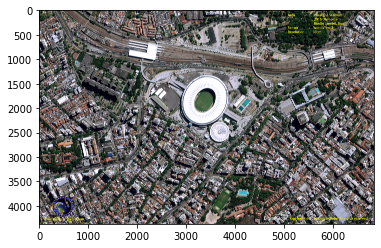

In [95]:
#opencvで画像のよみこみ

im = cv2.imread(test_path + files[1])
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#Image.fromarray(im_rgb).save('test.jpg')

plt.imshow(im_rgb)

#画像サイズの確認
v_size = im_rgb.shape[0]
h_size = im_rgb.shape[1]
print('v_size:', v_size)
print('h_size:', h_size)

30cm分解能の衛星画像なため，１５cm分解の航空画像の半分のピクセルで同一のスケールになる．

In [96]:
vn = v_size //50 #100pixleに分割
hn = h_size // 50

RGB


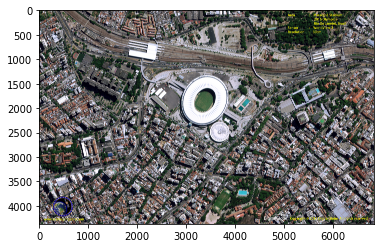

In [97]:
#PILで画像の読み込み

img = Image.open(test_path + files[1])
print(img.mode)
plt.imshow(np.array(img))

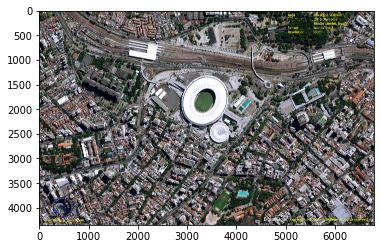

In [98]:
#画像サイズをグリッドの画像サイズの整数倍にリサイズする．
img_size_v = vn * 50
img_size_h = hn * 50


#画像のリサイズ・標準処理
img_resize=img.resize((img_size_h,img_size_v))
plt.imshow(img_resize)

デモ画像のDatasetおよびDataloaderを作成する．

In [99]:
#デモ画像を基準のグリッドサイズで分割する．

width = 50
height = 50


DIR_OUTPUTS = '../data/test/demo/image/'

#画像の分割処理関数
def ImgSplit(im):
    # 読み込んだ画像を100*100ピクセルのサイズに分割する．のサイズで72*72枚に分割する

    buff = []
    # 縦の分割枚数
    for h1 in range(int(vn)):
        # 横の分割枚数
        for w1 in range(int(hn)):
            w2 = w1 * height
            h2 = h1 * width
            #print(w2, h2, width + w2, height + h2)
            c = im.crop((w2, h2, width + w2, height + h2))
            buff.append(c)
    return buff

#画像の分割処理の実行
hi=0
for ig in ImgSplit(img_resize):
    hi=hi+1
    #print(hi)
    # 保存先フォルダの指定
    ig.save(DIR_OUTPUTS+str(hi)+".png")

In [100]:
#test_listの作成

def make_datapath_list_test(phase="test"):

    rootpath = "../data/test/demo/image"
    target_path = osp.join(rootpath +'/*.png')
    print(target_path)

    path_list = []  # ここに格納する

    # globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


# 実行
test_list = make_datapath_list_test(phase="test")


../data/test/demo/image/*.png


In [101]:
# test画像の前処理をするクラス
# resize, normalize and totnesorを行う．

class ImageTransform_test():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'test': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                #transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='test'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

In [102]:
#natsoatを用いてファイルの順番をソートする

from natsort import natsorted

test_list = natsorted(test_list)

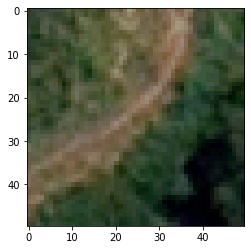

torch.Size([3, 96, 96])


In [103]:
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる

# 1. 画像読み込み
image_file_path = test_list[0]
img = Image.open(image_file_path).convert('RGB')   # [高さ][幅][色RGB]

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
size = 96
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="val")  # torch.Size([3, 224, 224])

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
print(img_transformed.shape)

In [104]:
# test画像のDatasetを作成する

class CarCountDataset_test(torch.utils.data.Dataset):
    """
    車の数の画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path).convert('RGB')   # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベルをファイル名から抜き出す
        label == 0
        return img_transformed, label


# 実行
test_dataset = CarCountDataset_test(
    file_list=test_list, transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 0
print(test_dataset.__getitem__(index)[0].size())
print(test_dataset.__getitem__(index)[1])

torch.Size([3, 96, 96])
tensor(1, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


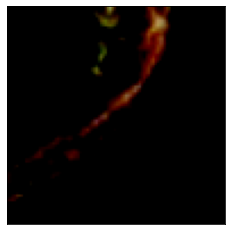

torch.Size([10, 3, 96, 96])
予測された車の数: 0
元の画像の表示


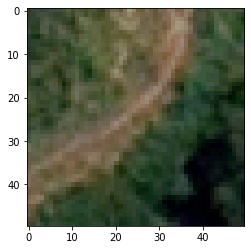

In [105]:
batch_size =10

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

dataiter = iter(test_dataloader)
images, labels = dataiter.next()  # サンプルを1つだけ取り出す

plt.imshow(np.transpose(images[0], (1, 2, 0)))  # チャンネルを一番後ろに
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.show()

net.eval()  # 評価モード
x, t = images.cuda(), labels.cuda()  # GPU対応
print(x.shape)
#x, t = images, labels # CPU対応
y = net(x)
print("予測された車の数:", y[0].argmax().item())

# 2. 元の画像の表示
print('元の画像の表示')
plt.imshow(img)
plt.show()

In [106]:
# ミニバッチのサイズを指定
batch_size = 10

#対象画像のdataloaderを作成
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

classes = list(range(13))
class_correct = list(0. for i in range(13))
class_total = list(0. for i in range(13))


net.eval()  # 評価モード

test =[]
i = 0

for data in test_dataloader:
    images, labels = data
    x, t = images.cuda(), labels.cuda() # GPU対応
    #x, t = images, labels  # CPU対応
    #outputs = net(x)
    #_, predicted = torch.max(outputs, 1)
    #print('predicted:', predicted)
    y = net(x)
    for i in range(len(y)):
        result = y[i].argmax().item() #GPUのtensorをnpに変換するにはargmaxを用いる必要がある．
        test.append(result)
    
print('分割された画像数: ', len(test))

分割された画像数:  11832


In [107]:
test2 = np.array(test)
cars_counted =test2.reshape(int(vn), int(hn))

In [108]:
#ファイル名とパスを確認する．
print(test_path + files[1])

../data/test/demo/Satellite-Image-2016-Olympics-Rio-De-Janeiro.jpg


In [109]:
file_path = test_path + files[1]

mosaic_image = io.imread(file_path)[:, :, :3]
mosaic_image=cv2.resize(mosaic_image, (img_size_h,img_size_v))

print(mosaic_image.shape)

(4350, 6800, 3)


In [110]:
car_max = 12 #label classes
class_num = car_max + 1
grid_size = width # width, vertical = 50

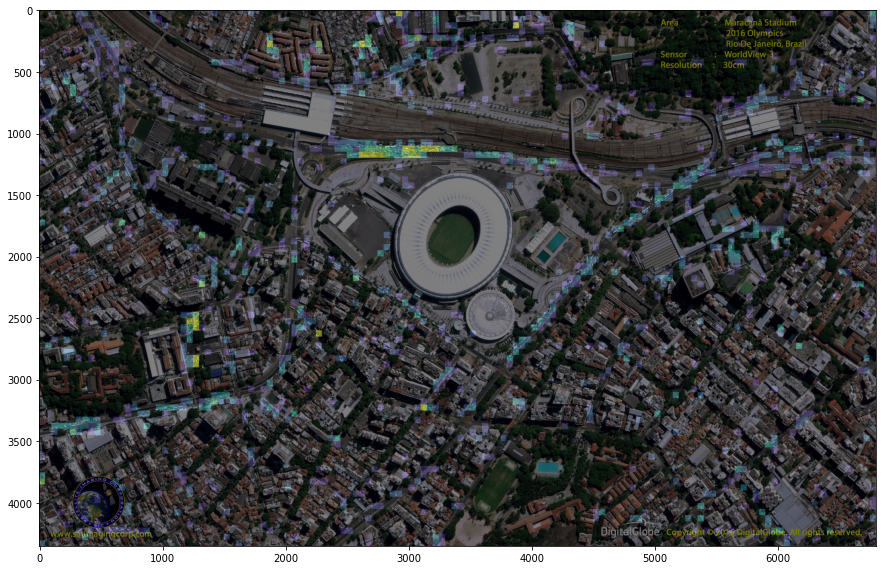

In [111]:
heatmap_overlayed = overlay_heatmap(cars_counted, mosaic_image, car_max, grid_size, cmap='viridis', line_thickness=-1)

fig = plt.figure(figsize=(15, 15))
plt.imshow(heatmap_overlayed)


plt.imsave('../data/result/heatmap_' + files[1], heatmap_overlayed)

In [112]:
heatmap_overlayed_2 = overlay_heatmap(cars_counted, mosaic_image, car_max, grid_size, cmap='Reds')

In [118]:
def plot_counts_on_heatmap_2(heatmap_overlayed, aoi_tblr, cars, grid_size, min_car_to_show=1, figsize=(100, 100)):
    
    top, bottom, left, right = aoi_tblr
    
    yi_min, xi_min = int(math.floor(top / grid_size)), int(math.floor(left / grid_size))
    yi_max, xi_max = int(math.ceil(bottom / grid_size)), int(math.ceil(right / grid_size))
    
    top, left, bottom, right = yi_min * grid_size, xi_min * grid_size, yi_max * grid_size, xi_max * grid_size
    
    fig = plt.figure(figsize=figsize)
    plt.imshow(heatmap_overlayed[top:bottom, left:right])
    
    for (yi, xi) in itertools.product(range(yi_min, yi_max), range(xi_min, xi_max)):
        
        car_num = cars[yi, xi]
        if car_num < min_car_to_show:
            continue
        
        plt.text(
            (xi + 0.5) * grid_size - left, (yi + 0.5) * grid_size - top, format(car_num, 'd'), 
            horizontalalignment="center", verticalalignment="center", color="black", size=25
        )
    
    plt.show()
    fig.savefig('../data/result/heatmap_carcount_' + files[1])
    

In [ ]:
top, bottom, left, right =  0, 1550,2000, 4000
heatmap_carcount = plot_counts_on_heatmap_2(heatmap_overlayed_2, (top, bottom, left, right), cars_counted, grid_size)